### Human Emotion Rating Data EDA

In [115]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr




In [4]:
#Load Data
exp1_rating = pd.read_csv('../data/human-data/exp1_preprocessed.csv')  
exp2_rating = pd.read_csv('../data/human-data/exp2_preprocessed.csv')  
exp3_rating = pd.read_csv('../data/human-data/exp3_preprocessed.csv')  


In [247]:
exp3_rating.columns

Index(['Image Name', 'Emotion', 'Participant_Private', 'Emo_Rating',
       'Liking_Rating', 'Emo_Time', 'Image Category', 'Attention Score',
       'Device', 'Order', 'mean concreteness (high-level)',
       'mean dynamic (high-level)', 'mean temperature (high-level)',
       'li: average hue (global)', 'li: average saturation (global)',
       'li: number of hues (global)', 'li: area of most frequent hue (global)',
       'li: hue contrast (global)', 'li: Hue model -3 (global)',
       'li: Hue model -1 (global)', 'li: Hue model 0 (global)',
       'li: Hue model 1 (global)', 'li: Hue model 2 (global)',
       'li: Hue model 3 (global)',
       'li: arithmetic average brightness (global)',
       'li: logarithmic average brightness (global)',
       'li: brightness contrast (global)', 'li: blurring effect (global)',
       'li: edge distribution metric (global)',
       'li: horizontal coordinate of mass center for largest segment',
       'li: vertical coordinate of mass center for 

In [172]:
#picking out emotion rating and combine two dataframes
cols = ['Participant_Private','Image Name', 'Image Category', 'Emotion', 'Emo_Rating']
exp1_rating_filtered = exp1_rating[cols].copy()
exp2_rating_filtered = exp2_rating[cols].copy()
exp3_rating_filtered = exp3_rating[cols].copy()
human_df = pd.concat([exp1_rating_filtered, exp2_rating_filtered,exp3_rating_filtered], axis=0, ignore_index=True)

human_df.rename(columns={
    'Participant_Private': 'participant',
    'Image Name':         'image',
    'Image Category':     'image_category',
    'Emo_Rating':         'emo_rating'
}, inplace=True)



In [173]:
#combine image and image_category into a single column
human_df['image'] = (
    human_df['image'].astype(str)
    + '_'
    + human_df['image_category'].astype(str)
)


In [174]:
human_df

,participant,image,image_category,Emotion,emo_rating
0,8685107.0,140abstract.jpg_leslie,leslie,Anger,78.0
1,8685107.0,141woman.jpg_leslie,leslie,Anger,25.0
2,8685107.0,145banjo.jpg_leslie,leslie,Anger,0.0
3,8685107.0,151guitar.jpg_leslie,leslie,Anger,60.0
4,8685107.0,170abstract.jpg_leslie,leslie,Anger,60.0
...,...,...,...,...,...
125072,13458459.0,la-jolla-arbor.jpg_impressionism,impressionism,Surprise,11.0
125073,13458459.0,lake-in-the-mountains-1899.jpg_impressionism,impressionism,Surprise,12.0
125074,13458459.0,not_detected_189365.jpg_abstract,abstract,Surprise,11.0
125075,13458459.0,not_detected_189367.jpg_abstract,abstract,Surprise,10.0


### Exploratory Data Analysis 

#### Functions

In [235]:
#box plot
def box_plot(df,df_name):
    plt.figure(figsize=(10,6))
    sns.boxplot(x='Emotion', y='emo_rating', data=df)
    plt.title(f'Box Plot of {df_name} Emotion Ratings by Emotion')
    plt.xlabel('Emotion')
    plt.ylabel('Emo_Rating')
    plt.tight_layout()
    plt.show()


In [239]:
#Overall histogram
def overall_histogram(df, df_name):
    plt.figure(figsize=(10,6))
    sns.histplot(df['emo_rating'], bins=30, kde=True, alpha=0.6)
    
    plt.title(f'Distribution of {df_name} Emotion Ratings')
    plt.xlabel('Emo_Rating')
    plt.ylabel('Count')
    plt.show()


In [245]:
#Histogram per emotion
def emotion_histogram(df, df_name):
    # Set up a FacetGrid: one panel per emotion
    g = sns.FacetGrid(df, col='Emotion', col_wrap=3, sharex=True, sharey=True, height=3.5)
    g.map(sns.histplot, 'emo_rating', bins=25, kde=True, alpha=0.6)

    # Labels & layout
    g.set_axis_labels('Rating', 'Count')
    g.fig.suptitle(f'Distribution of {df_name} Emotion Ratings', y=1.02)
    plt.tight_layout()
    plt.show()

In [263]:
# Emotion correlation heatmap
def image_category_heatmap(df, df_name):
    pivot_cat_em = (
        df
        .groupby(['image_category','Emotion'])['emo_rating']
        .mean()
        .unstack()
    )

    plt.figure(figsize=(8,6))
    sns.heatmap(
        pivot_cat_em,
        annot=True, fmt=".1f",
        cbar_kws={'label':'Mean Rating'}
    )
    plt.title(f'Mean {df_name} Rating by Image Category x Emotion')
    plt.ylabel('Image Category')
    plt.xlabel('Emotion')
    plt.show()

In [ ]:
# Correlation heatmap + dendrogram
def emotion_category(df, df_name):
    img_profiles = (
        df
        .groupby(['image','Emotion'])['emo_rating']
        .mean()
        .unstack()
    )

    corr = img_profiles.corr()

    # 4.3 Heatmap of emotion correlations
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, fmt=".2f", 
                cmap='vlag', center=0,
                cbar_kws={'label':'Pearson r'})
    plt.title(f'Correlation Among Emotions in {df_name}')
    plt.show()

    # 4.4 Dendrogram clustering of emotions
    linkage = sch.linkage(corr, method='average')
    plt.figure(figsize=(6,4))
    sch.dendrogram(linkage, labels=corr.columns, leaf_rotation=45)
    plt.title(f'Hierarchical Clustering of Emotions in {df_name}')
    plt.ylabel('Distance')
    plt.tight_layout()
plt.show()

In [268]:
def pca_biplot(df, df_name, group_key='image'):
    """
    df: DataFrame with columns ['image','Emotion','emo_rating']
    group_key: name of the column in df to group by (e.g. 'image' or 'image_category')
    """
    # 1) Build image × emotion matrix and drop any rows with missing values
    profiles = (
        df
        .groupby([group_key, 'Emotion'])['emo_rating']
        .mean()
        .unstack()
        .dropna(axis=0)
    )

    # 2) Standardize each emotion dimension
    scaler = StandardScaler()
    X = scaler.fit_transform(profiles.values)

    # 3) Fit PCA to 2 components
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)

    # 4) Build a plotting DataFrame
    vis_df = pd.DataFrame(
        coords,
        columns=['PC1','PC2'],
        index=profiles.index
    ).reset_index()

    # 5) Prepare loadings for arrows
    loadings = pca.components_.T
    # Scale arrows so they’re visible relative to the point cloud
    scale = np.max(np.abs(coords)) * 0.7

    # 6) Plot
    plt.figure(figsize=(8,6))
    # a) scatter of paintings
    sns.scatterplot(
        data=vis_df,
        x='PC1', y='PC2',
        alpha=0.6,
        s=50
    )
    # b) emotion vectors
    for i, emo in enumerate(profiles.columns):
        x_vec, y_vec = loadings[i] * scale
        plt.arrow(
            0, 0,
            x_vec, y_vec,
            color='red',
            width=0.005,
            head_width=0.1,
            length_includes_head=True
        )
        plt.text(
            x_vec * 1.1, y_vec * 1.1,
            emo,
            color='red',
            ha='center',
            va='center',
            fontsize=10
        )

    # 7) Labels and aesthetics
    var1, var2 = pca.explained_variance_ratio_ * 100
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.xlabel(f"PC1 ({var1:.1f}% var)")
    plt.ylabel(f"PC2 ({var2:.1f}% var)")
    plt.title(f" {df_name} PCA Biplot (Paintings x Emotion)")
    plt.tight_layout()
    plt.show()


### Analysis

In [236]:
#check number of unique participants 
human_df['participant'].nunique(), human_df['image'].nunique(), human_df['image_category'].nunique(), human_df['Emotion'].nunique()


(222, 972, 5, 6)

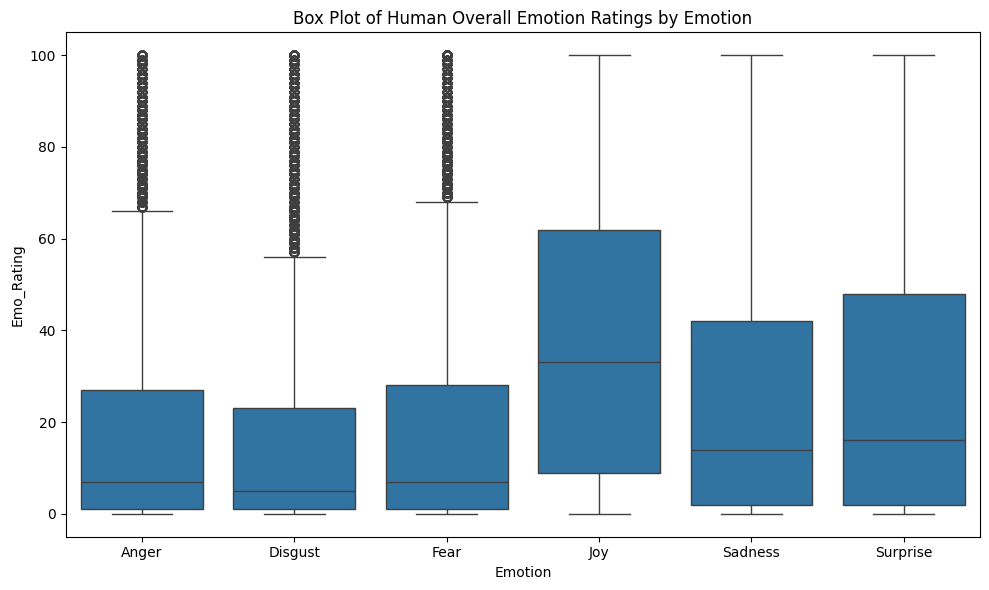

In [237]:
box_plot(human_df,'Human Overall')

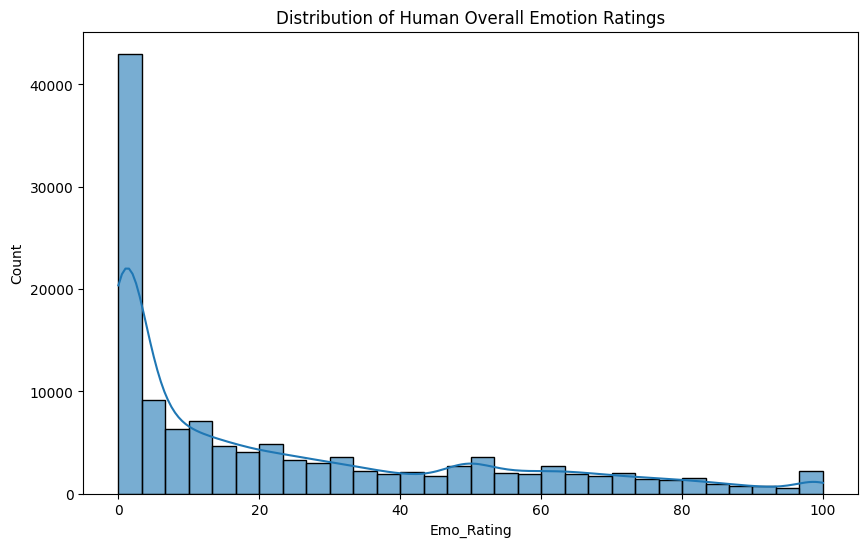

In [240]:
overall_histogram(human_df, 'Human Overall')

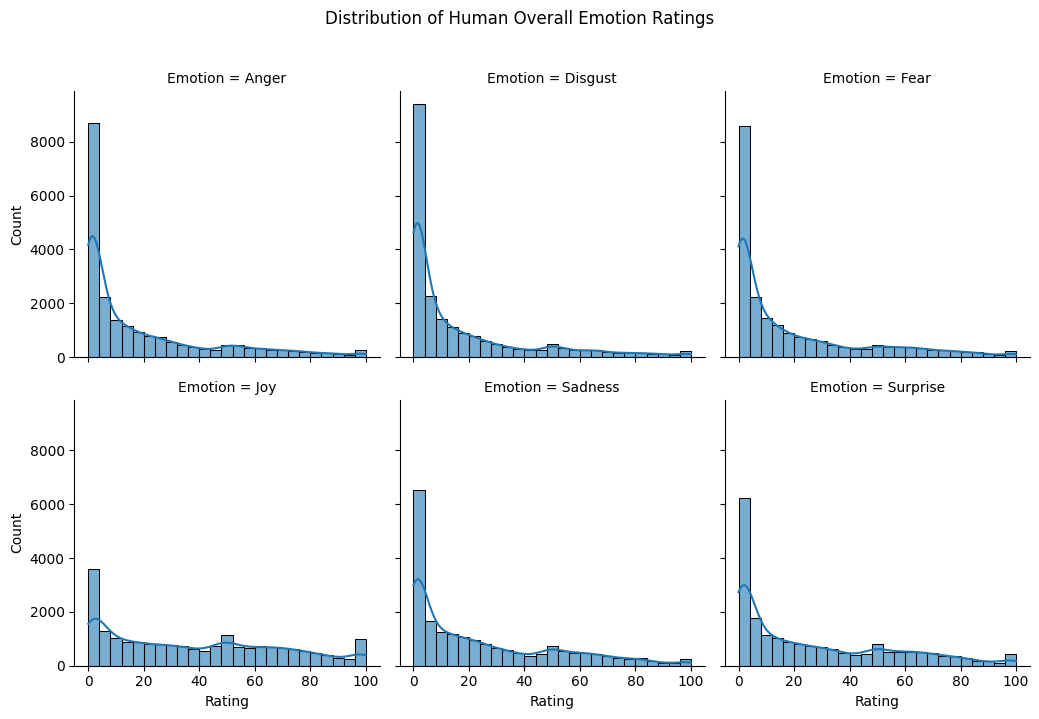

In [246]:
emotion_histogram(human_df, 'Human Overall')

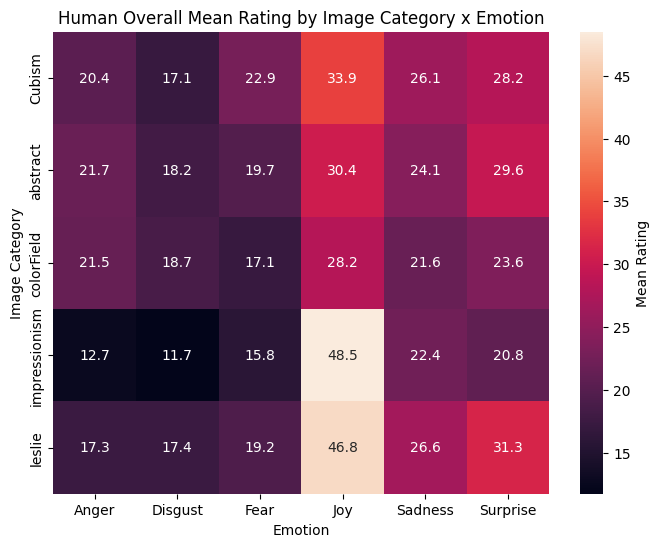

In [249]:
emotion_category(human_df, 'Human Overall')

In [251]:
emotion_correlation_heatmap(human_df, 'Human Overall')

ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed

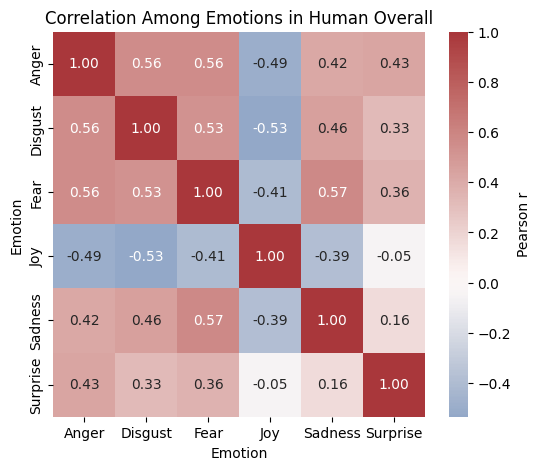

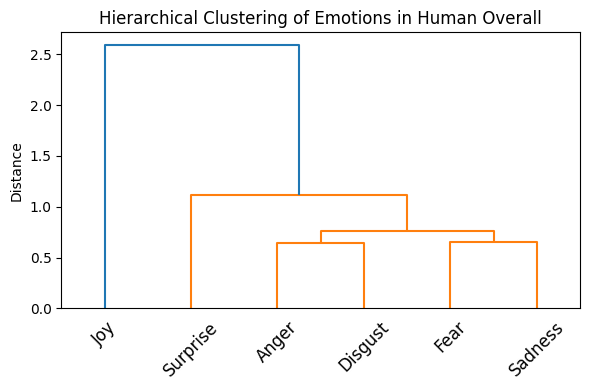

In [253]:
emotion_category(human_df, 'Human Overall')

### Import LLM data

In [182]:
# DF to have one row per image, with all emotion ratings
data_dir = Path("../output/analysis_output")
emotions = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "liking"]

categories = {p.stem.split("_", 1)[1]
              for p in data_dir.glob("*.csv")}

merged_by_cat = []

for cat in categories:
    df_cat = None
    for emo in emotions:
        path = data_dir / f"{emo}_{cat}.csv"
        if not path.exists():
            continue  
        df = pd.read_csv(path)

        df = df.rename(columns={
            "Emo_Rating":      f"{emo}_rating",
            "Explanation":      f"{emo}_explanation"
        })

        df = df[["image", "image_category",
                 f"{emo}_rating", f"{emo}_explanation"]]
        if df_cat is None:
            df_cat = df
        else:
            df_cat = df_cat.merge(
                df,
                on=["image", "image_category"],
                how="outer"
            )
    merged_by_cat.append(df_cat)

# 3. Stack all categories into one DataFrame
llm_score_per_image = pd.concat(merged_by_cat, ignore_index=True)


In [183]:
all_dfs = []

for csv_path in data_dir.glob("*.csv"):
    # infer emotion key from filename
    emo = csv_path.stem.split("_", 1)[0].lower()

    df = pd.read_csv(csv_path)
    # rename the dynamic columns → generic names
    df = df.rename(columns={
        f"{emo}_rating":       "emo_rating",
        f"{emo}_explanation":  "emo_explanation"
    })
    # add the Emotion column
    df["Emotion"] = emo.capitalize()

    # select & reorder the five columns you want
    df = df[[
        "image",
        "image_category",
        "Emotion",
        "emo_rating",
        "emo_explanation"
    ]]
    all_dfs.append(df)

# concatenate everything into one long table
llm_concat_ratings = pd.concat(all_dfs, ignore_index=True)

#concat_ratings.to_csv("../data/merged_emotions_concatenated.csv", index=False)



In [190]:
#take out liking ratiang for now
llm_df = llm_concat_ratings[llm_concat_ratings['Emotion'] != 'Liking'].copy()

In [191]:
#combine image and image_category into a single column
llm_df['image'] = (
    llm_df['image'].astype(str)
    + '_'
    + llm_df['image_category'].astype(str)
)

#### Exploratory on LLM data

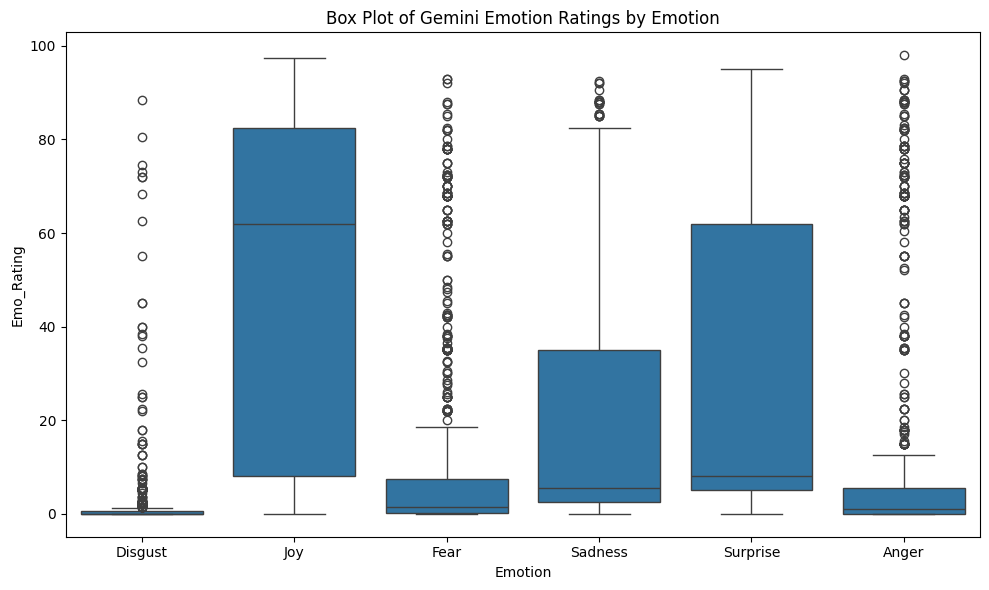

In [256]:
box_plot(llm_df,'Gemini')

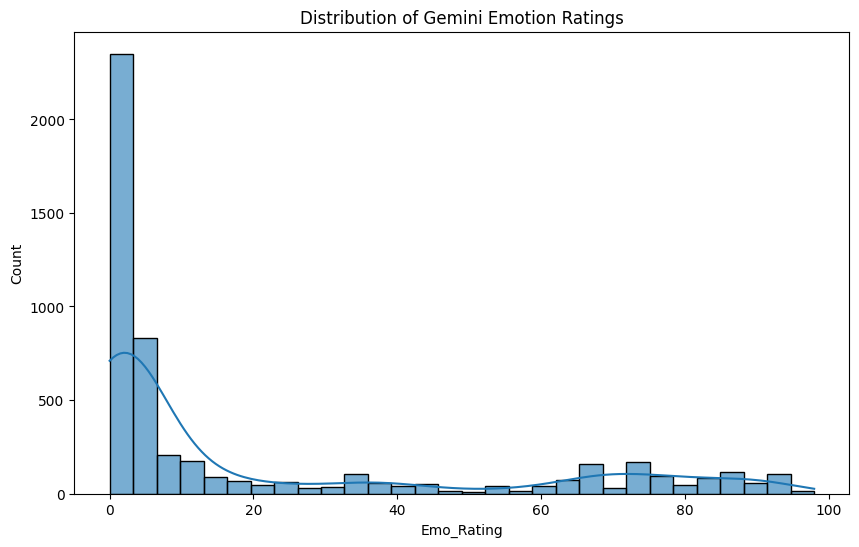

In [257]:
overall_histogram(llm_df, 'Gemini')

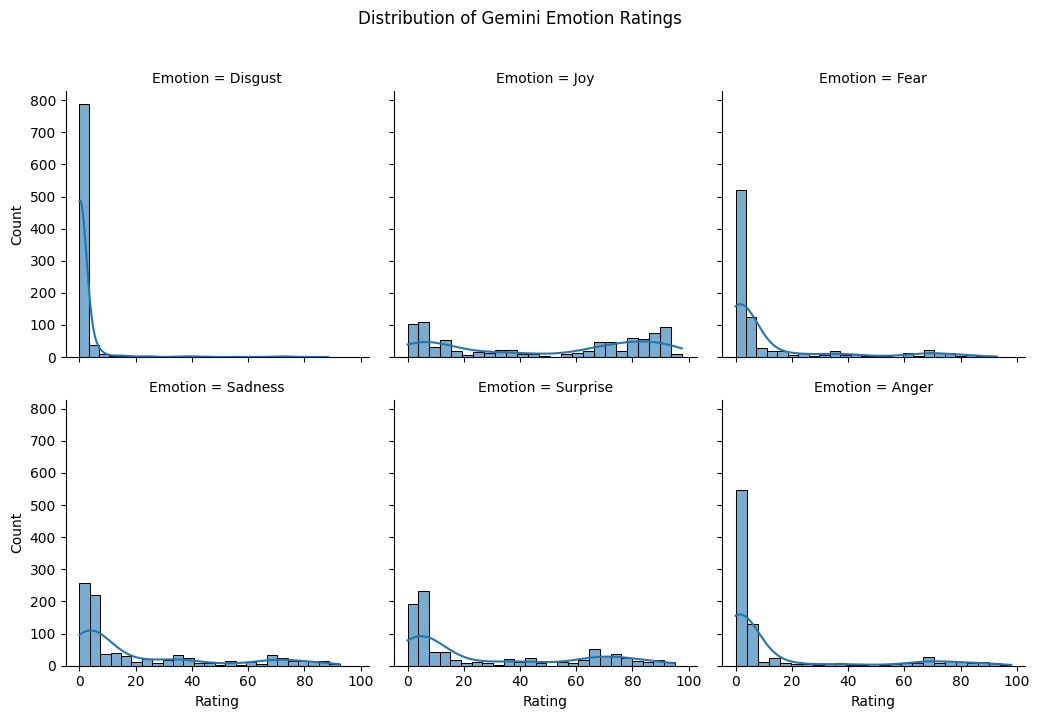

In [258]:
emotion_histogram(llm_df, 'Gemini')

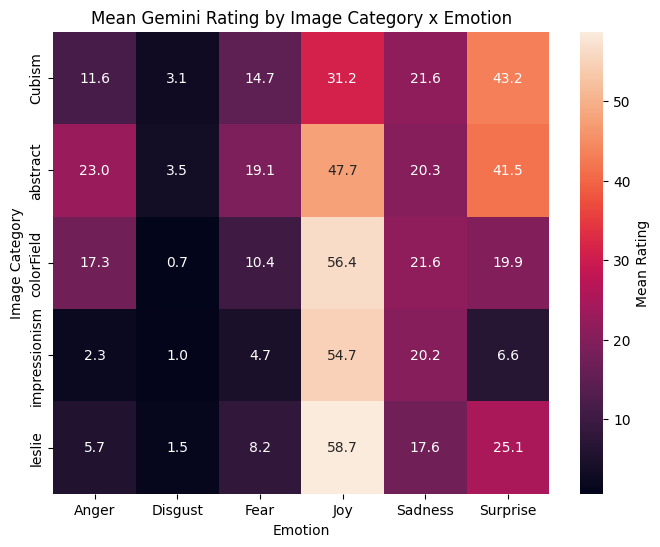

In [264]:
image_category_heatmap(llm_df, 'Gemini')

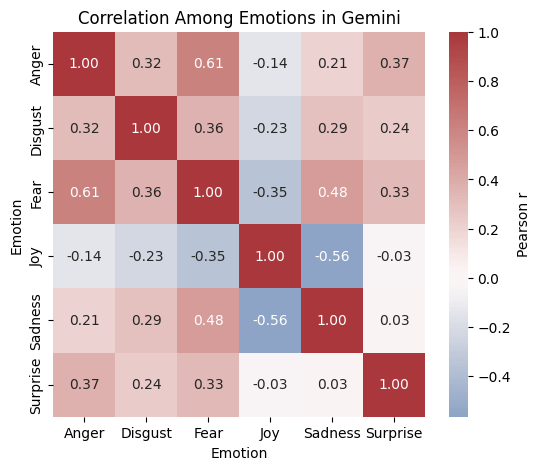

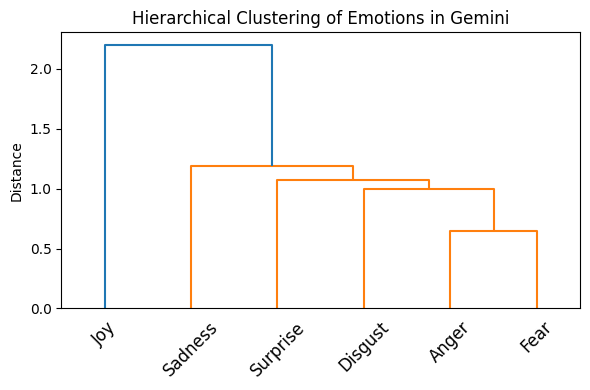

In [259]:
emotion_category(llm_df, 'Gemini')

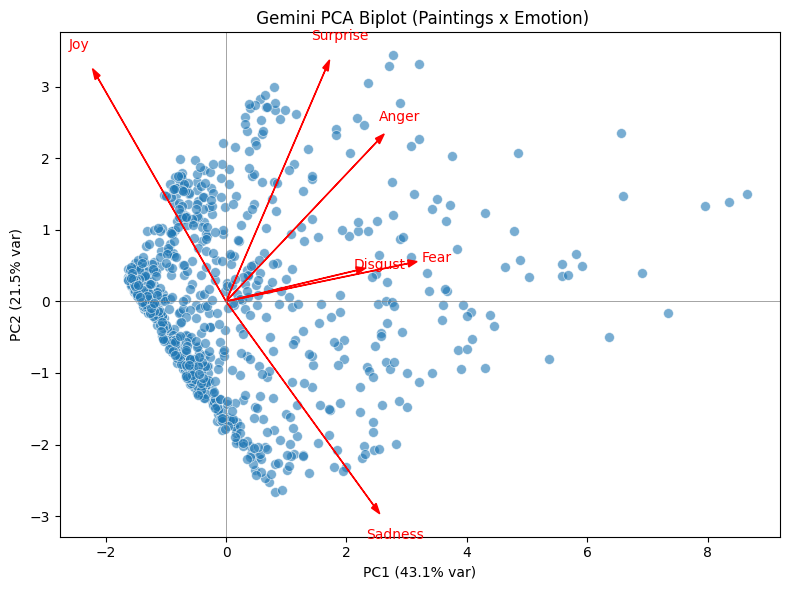

In [269]:
pca_biplot(llm_df, 'Gemini')

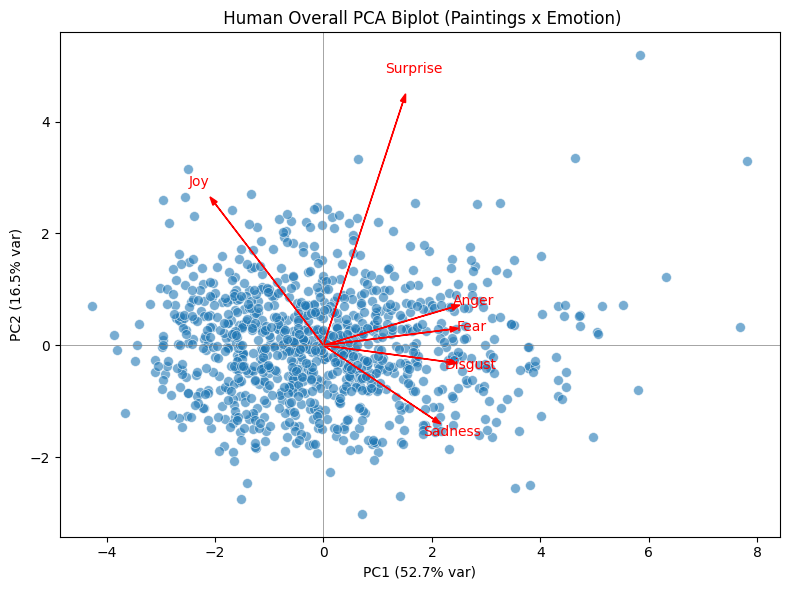

In [270]:
pca_biplot(human_df, 'Human Overall')

### Now Compare Human vs LLM data

In [198]:
human_df['n_ratings'] = (
    human_df
      .groupby(['image','Emotion'])['emo_rating']
      .transform('count')
)

In [200]:
human_df

,participant,image,image_category,Emotion,emo_rating,n_ratings
0,8685107.0,140abstract.jpg_leslie,leslie,Anger,78.0,24
1,8685107.0,141woman.jpg_leslie,leslie,Anger,25.0,17
2,8685107.0,145banjo.jpg_leslie,leslie,Anger,0.0,24
3,8685107.0,151guitar.jpg_leslie,leslie,Anger,60.0,46
4,8685107.0,170abstract.jpg_leslie,leslie,Anger,60.0,15
...,...,...,...,...,...,...
125072,13458459.0,la-jolla-arbor.jpg_impressionism,impressionism,Surprise,11.0,14
125073,13458459.0,lake-in-the-mountains-1899.jpg_impressionism,impressionism,Surprise,12.0,28
125074,13458459.0,not_detected_189365.jpg_abstract,abstract,Surprise,11.0,107
125075,13458459.0,not_detected_189367.jpg_abstract,abstract,Surprise,10.0,107


In [201]:
human_df[(human_df['image']=='140abstract.jpg_leslie')&(human_df['Emotion']=='Anger')]

,participant,image,image_category,Emotion,emo_rating,n_ratings
0,8685107.0,140abstract.jpg_leslie,leslie,Anger,78.0,24
28438,11140955.0,140abstract.jpg_leslie,leslie,Anger,0.0,24
30052,11140988.0,140abstract.jpg_leslie,leslie,Anger,73.0,24
32488,11140995.0,140abstract.jpg_leslie,leslie,Anger,5.0,24
36526,11141005.0,140abstract.jpg_leslie,leslie,Anger,1.0,24
38146,11141013.0,140abstract.jpg_leslie,leslie,Anger,0.0,24
40570,11141039.0,140abstract.jpg_leslie,leslie,Anger,2.0,24
47854,11141112.0,140abstract.jpg_leslie,leslie,Anger,22.0,24
48658,11141120.0,140abstract.jpg_leslie,leslie,Anger,1.0,24
53500,11141206.0,140abstract.jpg_leslie,leslie,Anger,0.0,24


In [202]:
variation_stats = (
    human_df
      .groupby(['image','Emotion'])['emo_rating']
      .agg(
         count='count',      # number of ratings
         mean='mean',        # average rating
         std='std',          # standard deviation
         var='var',          # variance
         min='min',          # lowest rating
         max='max',          # highest rating
         q1=lambda x: x.quantile(0.25),  # 1st quartile
         q3=lambda x: x.quantile(0.75)   # 3rd quartile
      )
      .reset_index()
)

print(variation_stats.head())


                               image  Emotion  count       mean        std  \
0  01Klimt-Beethovenfries.png_leslie    Anger     15  14.666667  22.366003   
1  01Klimt-Beethovenfries.png_leslie  Disgust     22  36.045455  35.652392   
2  01Klimt-Beethovenfries.png_leslie     Fear     18  14.222222  22.356880   
3  01Klimt-Beethovenfries.png_leslie      Joy     16  40.125000  35.633084   
4  01Klimt-Beethovenfries.png_leslie  Sadness     19  18.894737  19.461914   

           var  min    max    q1     q3  
0   500.238095  0.0   72.0  0.50  20.00  
1  1271.093074  0.0  100.0  2.75  61.50  
2   499.830065  0.0   86.0  0.25  19.25  
3  1269.716667  1.0  100.0  6.50  69.25  
4   378.766082  0.0   53.0  0.00  31.50  


In [279]:
#calculate weighted average score per image per emotion for human rating
human_avg_df = (
    human_df
      .groupby(['image','image_category','Emotion'])
      .apply(lambda g: np.average(g['emo_rating'], weights=g['n_ratings']))
      .reset_index(name='emo_rating')
)

human_avg_df

/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_58349/2404198638.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g['emo_rating'], weights=g['n_ratings']))


,image,image_category,Emotion,emo_rating
0,01Klimt-Beethovenfries.png_leslie,leslie,Anger,14.666667
1,01Klimt-Beethovenfries.png_leslie,leslie,Disgust,36.045455
2,01Klimt-Beethovenfries.png_leslie,leslie,Fear,14.222222
3,01Klimt-Beethovenfries.png_leslie,leslie,Joy,40.125000
4,01Klimt-Beethovenfries.png_leslie,leslie,Sadness,18.894737
...,...,...,...,...
5796,zinc-1917.jpg_Cubism,Cubism,Disgust,23.576923
5797,zinc-1917.jpg_Cubism,Cubism,Fear,25.571429
5798,zinc-1917.jpg_Cubism,Cubism,Joy,30.269231
5799,zinc-1917.jpg_Cubism,Cubism,Sadness,35.892857


Top 10 images by standard deviation per emotion:
     Emotion                                              image        std
0      Anger                      untitled-2012-71.jpg_abstract  39.585027
1      Anger         variation-z-rtlichkeiten-1917.jpg_abstract  39.571422
2      Anger                          elements-v.jpg_colorField  39.418116
3      Anger                                 78imari.jpg_leslie  39.405342
4      Anger                    beta-lambda-1961.jpg_colorField  38.694217
5      Anger                            red-jew-1915.jpg_Cubism  38.382432
6      Anger                        citadel-1962.jpg_colorField  38.318001
7      Anger                           self-portrait.jpg_Cubism  38.267480
8      Anger                           alya-1964.jpg_colorField  37.896451
9      Anger                      canto-xiv-1964.jpg_colorField  37.440024
10   Disgust          composizione-in-azzurro-1965.jpg_abstract  38.789252
11   Disgust                    untitled-1985-11.jp

/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_58349/1304069170.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(10, 'std'))


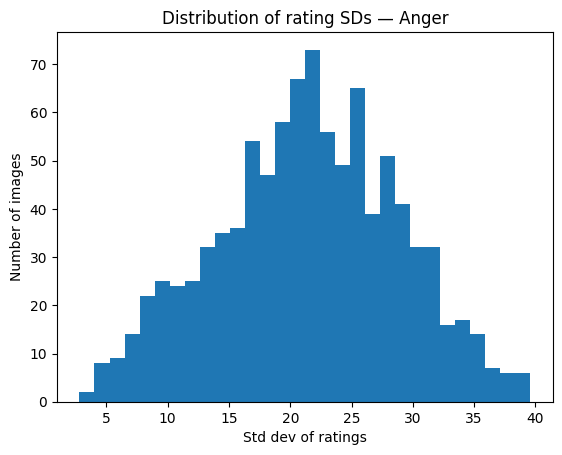

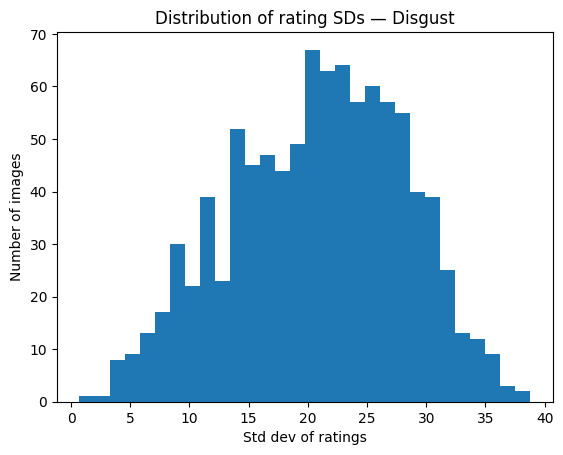

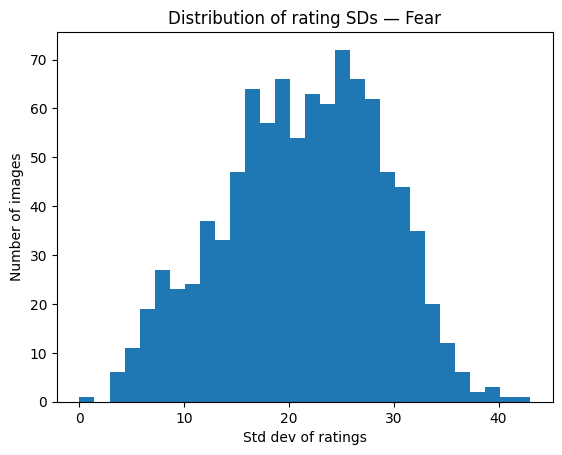

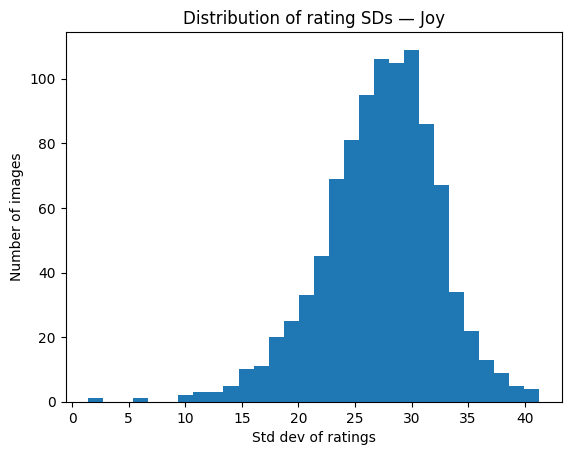

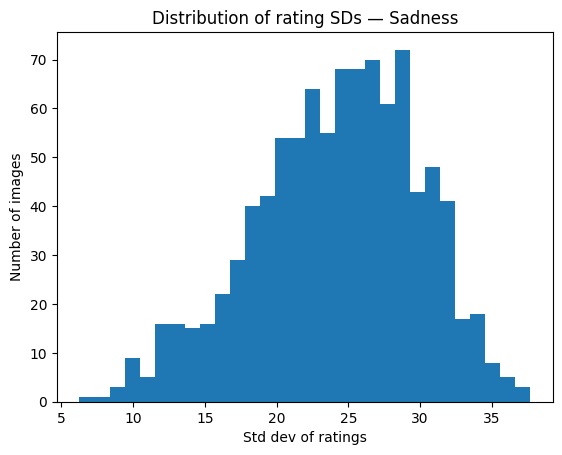

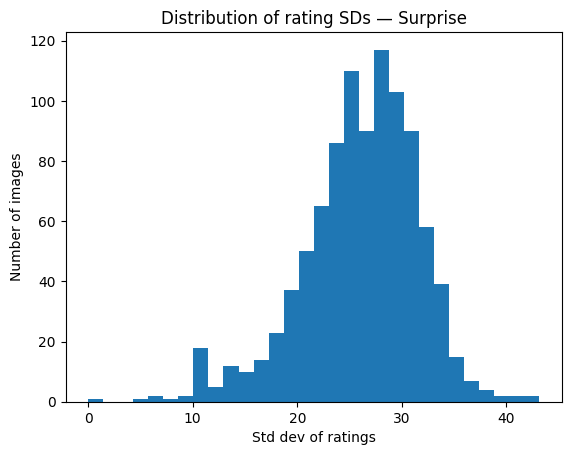

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Compute count, mean, and SD per image × emotion
variation_stats = (
    human_df
      .groupby(['image','Emotion'])['emo_rating']
      .agg(
         count='count',
         mean='mean',
         std='std'
      )
      .reset_index()
)

# 2. Look at the top 10 most-disagreed images for each emotion
top_var = (
    variation_stats
      .dropna(subset=['std'])                # drop groups with <2 ratings
      .groupby('Emotion')
      .apply(lambda g: g.nlargest(10, 'std'))
      .reset_index(drop=True)
)

print("Top 10 images by standard deviation per emotion:")
print(top_var[['Emotion','image','std']])


# 3. Plot the spread of SDs across images for each emotion
for emo in variation_stats['Emotion'].unique():
    stds = variation_stats.loc[
        variation_stats['Emotion']==emo, 'std'
    ].dropna()
    plt.figure()
    plt.hist(stds, bins=30)
    plt.xlabel('Std dev of ratings')
    plt.ylabel('Number of images')
    plt.title(f'Distribution of rating SDs — {emo}')
    plt.show()


### EDA for Average Human data

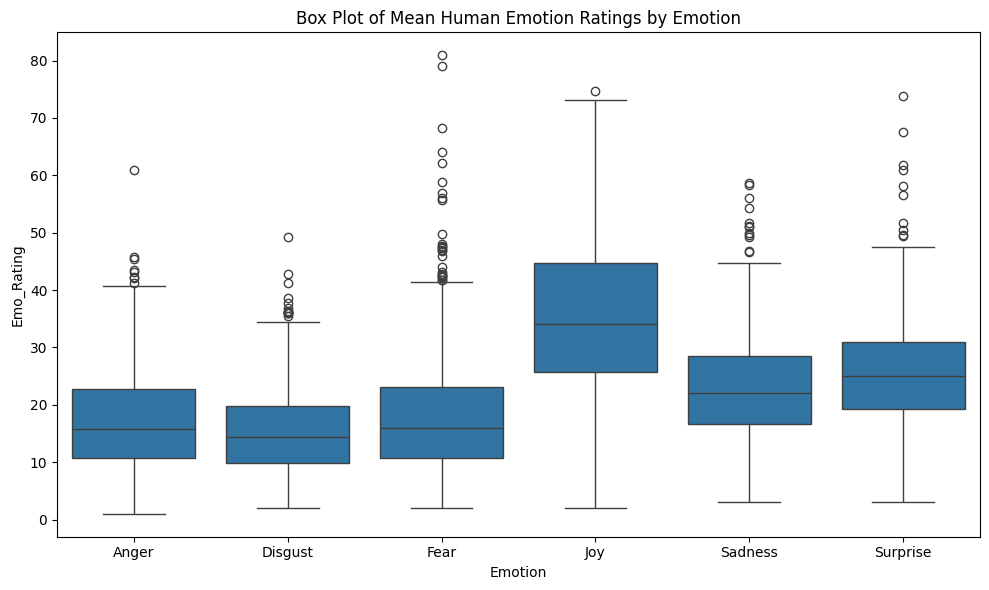

In [281]:
box_plot(human_avg_df,'Mean Human')

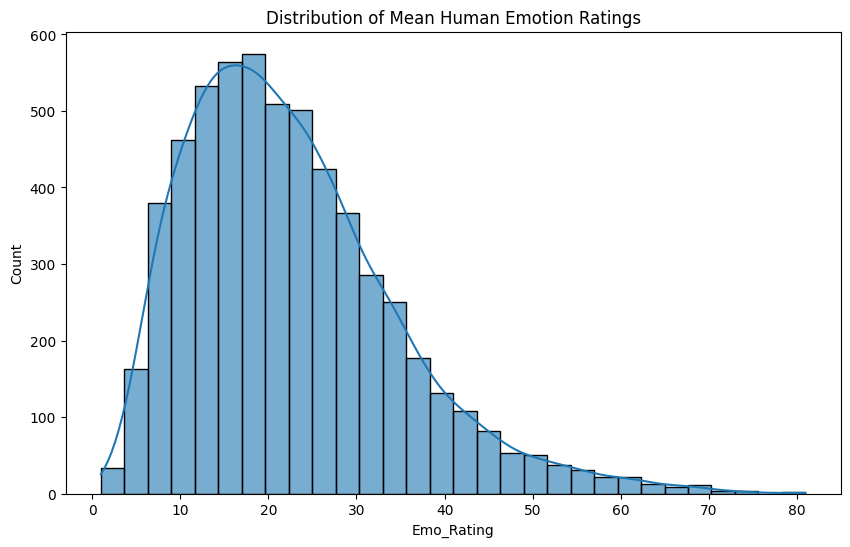

In [282]:
overall_histogram(human_avg_df,'Mean Human')

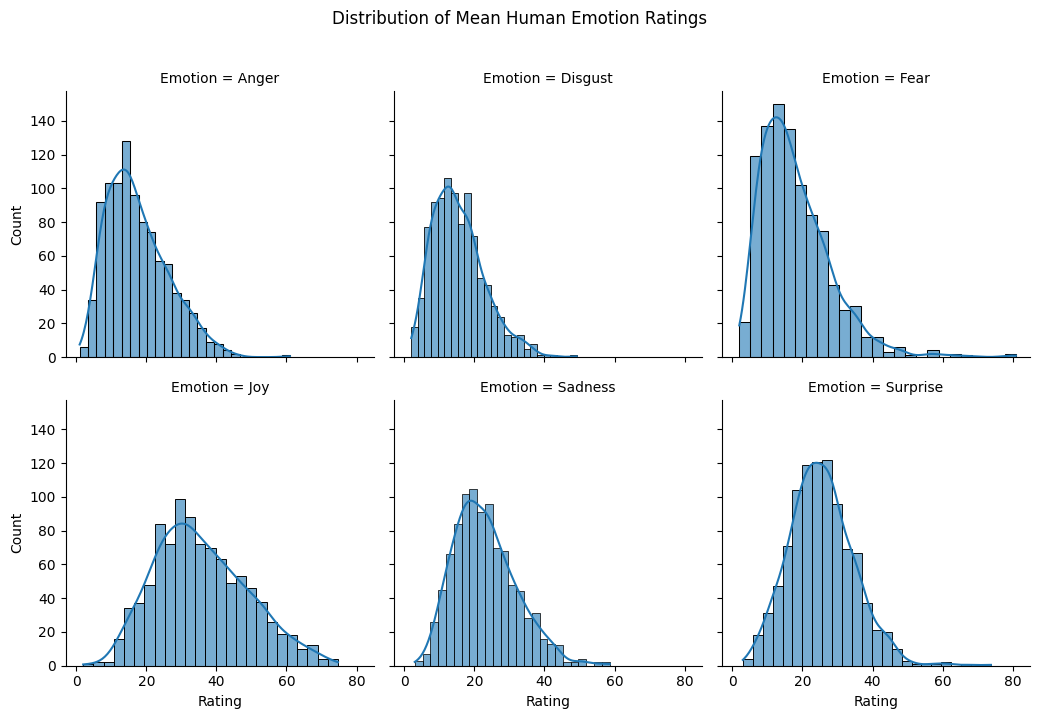

In [283]:
emotion_histogram(human_avg_df,'Mean Human')

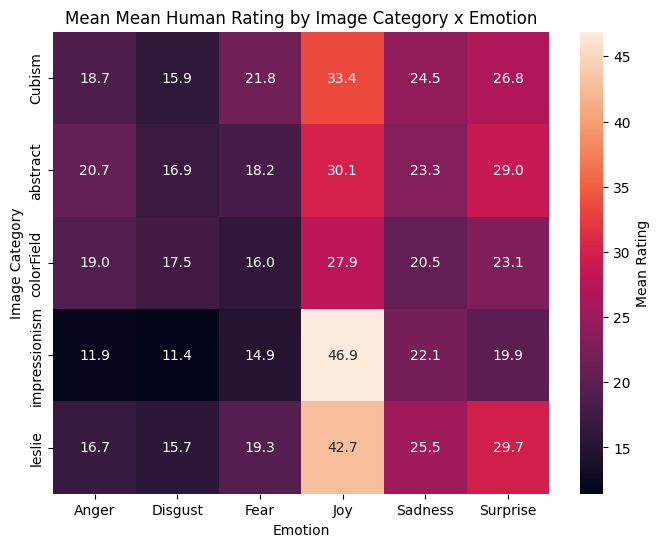

In [284]:
image_category_heatmap(human_avg_df,'Mean Human')

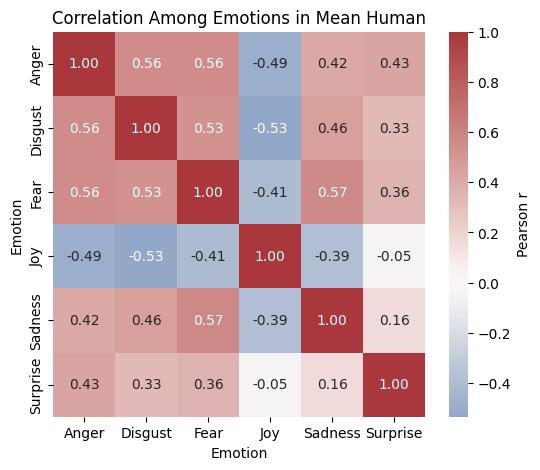

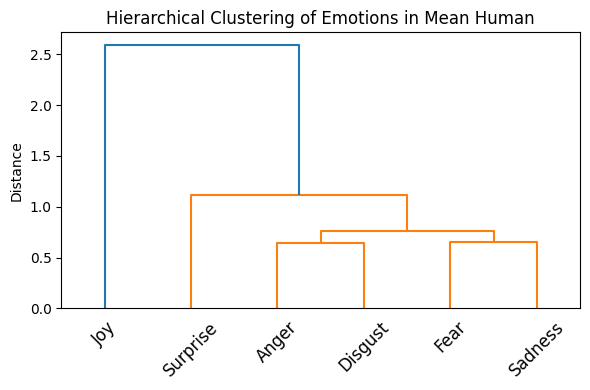

In [285]:
emotion_category(human_avg_df,'Mean Human')

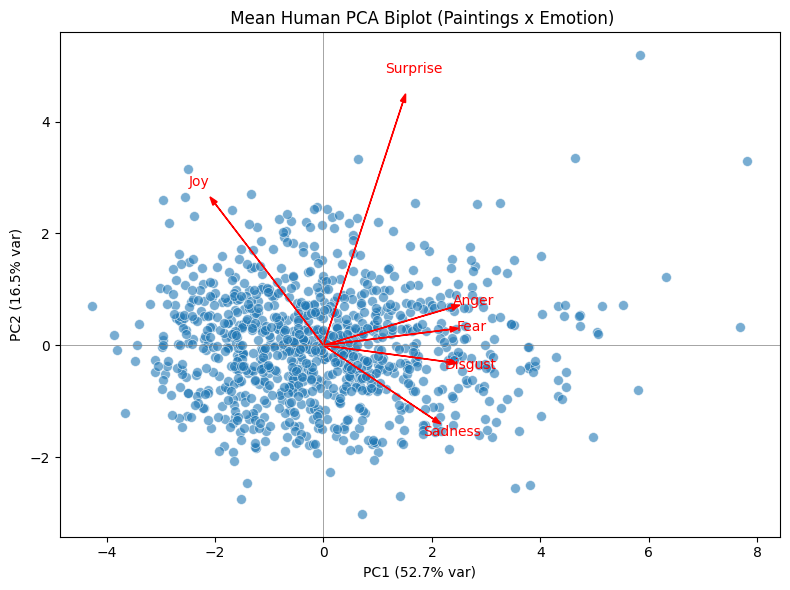

In [286]:
pca_biplot(human_avg_df,'Mean Human')

In [207]:
#match images that are present in both human and LLM ratings
common = set(human_avg_df['image']).intersection(llm_df['image'])
human_sub = human_avg_df[human_avg_df['image'].isin(common)]
llm_sub   = llm_df[llm_df['image'].isin(common)]


In [208]:
#merge human and LLM df
merged_rating = pd.merge(
    human_sub,
    llm_sub,
    on=['image','Emotion'],
    suffixes=('_human','_llm')
)
# merged now has columns: image, Emotion, human_rating, llm_rating
merged_rating = merged_rating.dropna(subset=['emo_rating_human', 'emo_rating_llm'])

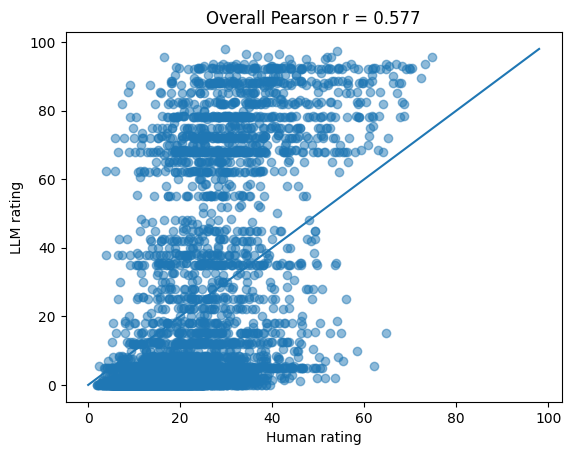

Anger: r = 0.410


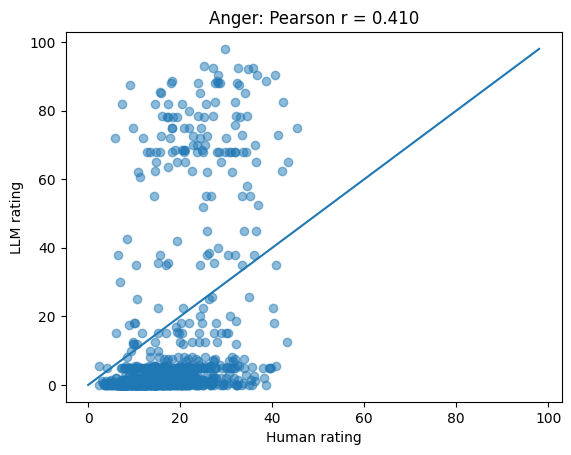

Disgust: r = 0.179


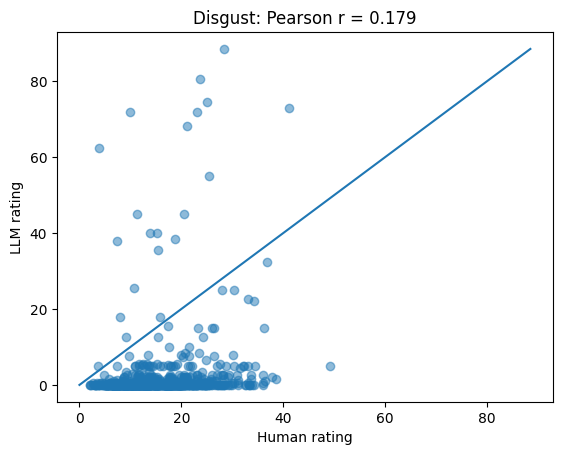

Fear: r = 0.468


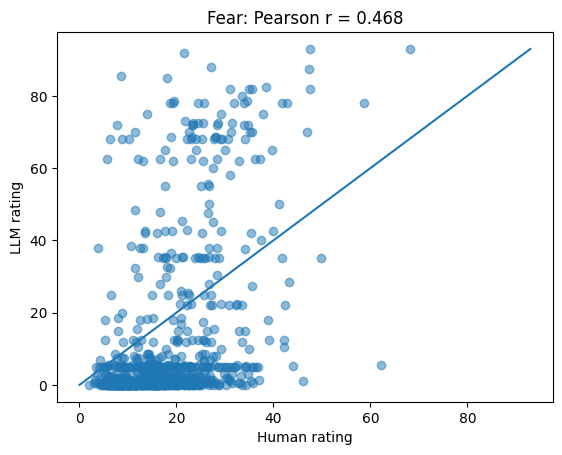

Joy: r = 0.412


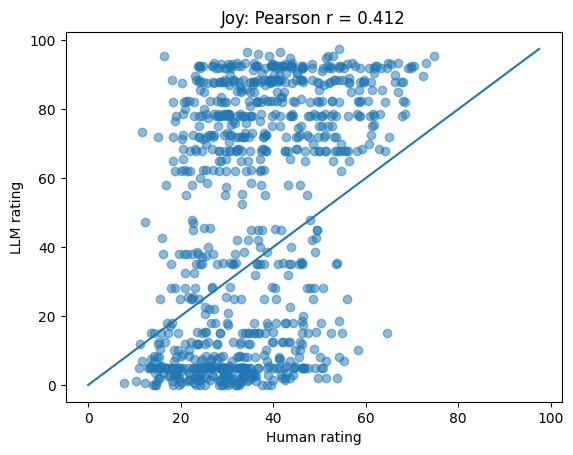

Sadness: r = 0.507


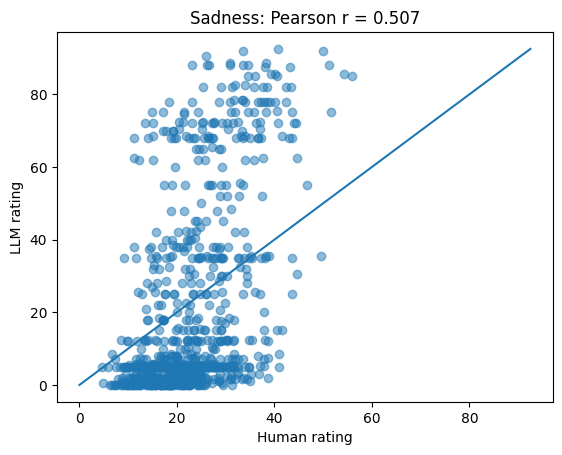

Surprise: r = 0.385


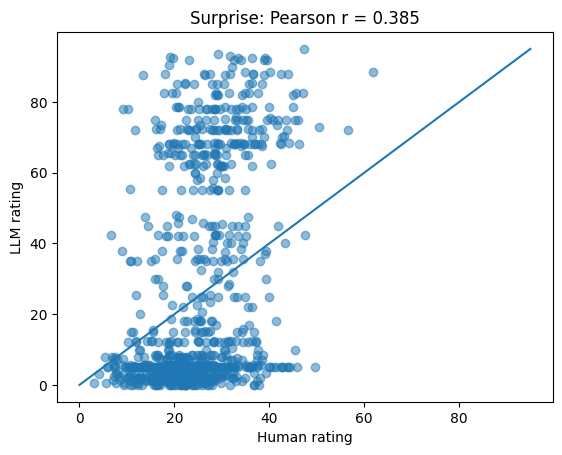

In [271]:
# Overall relationship
x = merged_rating['emo_rating_human']
y = merged_rating['emo_rating_llm']
r_all, _ = pearsonr(x, y)

plt.figure()
plt.scatter(x, y, alpha=0.5)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims)
plt.xlabel('Human rating')
plt.ylabel('LLM rating')
plt.title(f'Overall Pearson r = {r_all:.3f}')
plt.show()

pearson_corrs = []
# Per‐emotion plots
for emo in merged_rating['Emotion'].unique():
    sub = merged_rating[merged_rating['Emotion'] == emo]
    x = sub['emo_rating_human']
    y = sub['emo_rating_llm']
    r, _ = pearsonr(x, y)
    pearson_corrs.append((emo, r))
    print(f"{emo}: r = {r:.3f}")

    plt.figure()
    plt.scatter(x, y, alpha=0.5)
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    plt.plot(lims, lims)
    plt.xlabel('Human rating')
    plt.ylabel('LLM rating')
    plt.title(f'{emo}: Pearson r = {r:.3f}')
    plt.show()


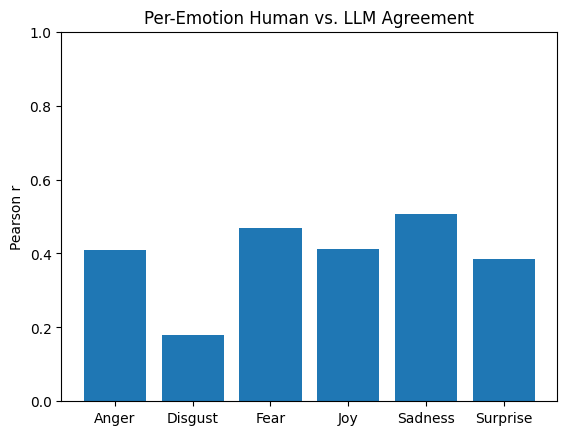

In [272]:

plt.figure()
plt.bar([emo for emo, _ in pearson_corrs], [r for _, r in pearson_corrs])
plt.ylabel('Pearson r')
plt.ylim(0,1)
plt.title('Per-Emotion Human vs. LLM Agreement')
plt.show()


### ------------------------END-----------------------------

In [113]:
#mat_data = loadmat('../data/human-data/image_mean_rating.mat') I don't care about this for now

In [114]:
print(mat_data.keys())

NameError: name 'mat_data' is not defined

In [ ]:
# Extract and squeeze data (MATLAB often returns extra dimensions)
image_names = mat_data['image_names'].squeeze()
image_categories = mat_data['image_categories'].squeeze()
mean_scores = mat_data['mean_score'].squeeze()

# Optional: decode strings if needed
if isinstance(image_names[0], np.ndarray):
    image_names = [name[0] for name in image_names]
if isinstance(image_categories[0], np.ndarray):
    image_categories = [cat[0] for cat in image_categories]

# Create DataFrame
rating_df = pd.DataFrame({
    'image_name': image_names,
    'image_category': image_categories,
    'mean_score': mean_scores
})


In [ ]:
#aesthetic rating from Kyo, one score per painting
rating_df

,image_name,image_category,mean_score
0,a-fisherman-s-cottage.jpg,impressionism,2.783133
1,a-grey-day-carmel.jpg,impressionism,3.098361
2,a-misty-morning.jpg,impressionism,3.023438
3,a-mother-and-son-seated-by-a-wall-before-the-s...,impressionism,2.593220
4,a-spanish-barracks-1906.jpg,impressionism,2.633333
...,...,...,...
821,woman-and-bird-1930.jpg,Cubism,NaN
822,woman-on-a-balcony-1914.jpg,Cubism,2.368852
823,woman-with-mandolin-1925.jpg,Cubism,NaN
824,workbox.jpg,Cubism,2.409836
